In [81]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Считывание датасета.

In [3]:
data = pd.read_csv('data/train2.csv')

In [4]:
csr_cal = csr_matrix((data['sum'].values, (data['id'].values - 1, data['date'].values - 1)))
user_cnt, day_cnt = csr_cal.shape
days_in_week = 7

In [5]:
X = np.array(csr_cal.todense())

In [6]:
X = X[:, day_cnt % days_in_week:]

In [7]:
#Разделение на валидационную и тестовую выборки.
X_train = X[:, days_in_week:] # для паблика
X_val = X[:, :-days_in_week] # на локальный контроль

last_buy_day = np.argmax(X_train[:, :-days_in_week - 1:-1] != 0, axis=1) #первая покупка за последнюю неделю.
y_val = X_train[:, :-days_in_week - 1:-1][np.arange(user_cnt), last_buy_day]

## Анализ датасета.

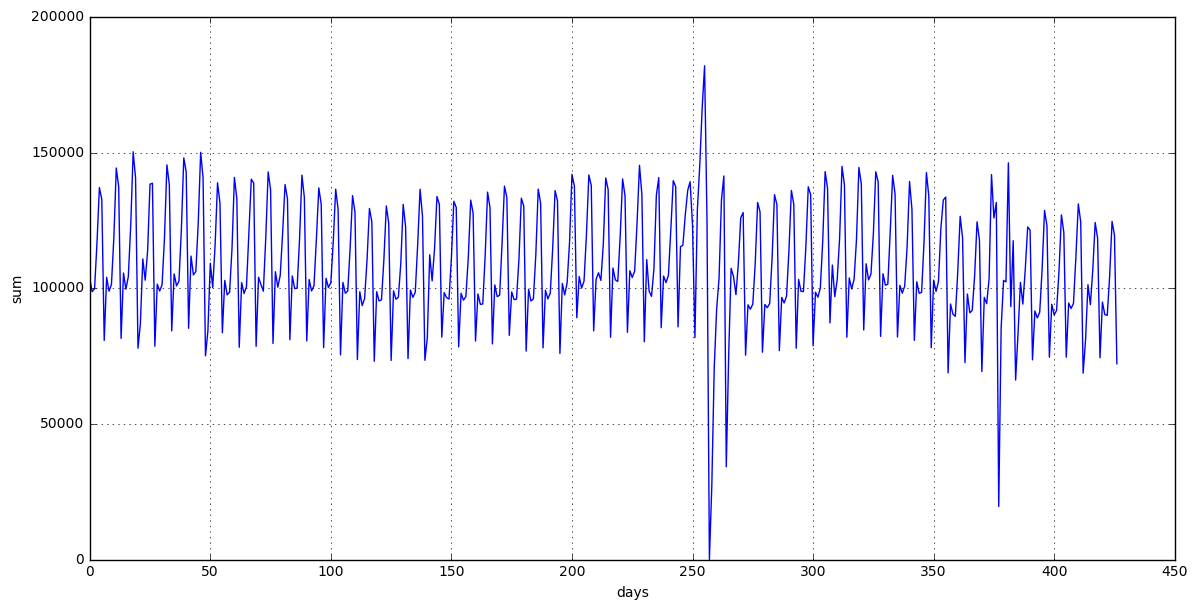

In [181]:
sum_buy = X_train.sum(axis=0)
plt.figure(figsize=(14, 7))
plt.xlabel('days')
plt.ylabel('sum')
plt.grid()
plt.plot(np.arange(sum_buy.shape[0]), sum_buy)

## Простые весовые схемы.

In [119]:
def calculate_weights_1(day_cnt, gamma=1):
    weeks_cnt = day_cnt // days_in_week
    weights = 1. / (np.arange(1, weeks_cnt + 1)) ** gamma
    weights = weights[::-1]
    return weights

def calculate_weights_2(day_cnt):
    weeks_cnt = day_cnt // days_in_week
    return np.arange(weeks_cnt)

def calculate_weights_3(day_cnt, beta=0.99, gamma=1):
    weeks_cnt = day_cnt // days_in_week
    weights = beta ** (np.arange(1, weeks_cnt + 1) ** gamma)
    weights = weights[::-1]
    return weights

In [121]:
def predict(X, weights):
    user_cnt = X.shape[0]
    y_pred = np.zeros(user_cnt)
    prob_sum_user = np.zeros((user_cnt, 17))
    for i in range(user_cnt):
        user = X[i, :].reshape(-1, days_in_week)
        weeks_cnt = user.shape[0]
        first_buy_day = np.argmax(user != 0, axis=1)
        first_buy_sum = user[np.arange(weeks_cnt), first_buy_day]
        prob_sum_user[i, :] = weights.dot(csr_matrix((np.ones(weeks_cnt), (np.arange(weeks_cnt), 
                                            first_buy_sum)), shape=(weeks_cnt, 17)).toarray())
    y_pred = np.argmax(prob_sum_user, axis=1)
    prob_sum_user /= prob_sum_user.sum(axis=1)[:, np.newaxis]
    return y_pred, prob_sum_user

In [122]:
%%time
gamma_val = np.linspace(0, 1.0, 11)
cross_val_acc = np.zeros(gamma_val.shape[0])

for i, gamma in enumerate(gamma_val):
    weights = calculate_weights_1(X_val.shape[1], gamma=gamma)
    y_pred, y_prob = predict(X_val, weights)
    cross_val_acc[i] = accuracy_score(y_pred, y_val)
    print("gamma: ", gamma, "accuracy: ", cross_val_acc[i])

gamma:  0.0 accuracy:  0.3071
gamma:  0.1 accuracy:  0.315236363636
gamma:  0.2 accuracy:  0.327872727273
gamma:  0.3 accuracy:  0.342536363636
gamma:  0.4 accuracy:  0.353336363636
gamma:  0.5 accuracy:  0.360063636364
gamma:  0.6 accuracy:  0.3628
gamma:  0.7 accuracy:  0.362354545455
gamma:  0.8 accuracy:  0.358163636364
gamma:  0.9 accuracy:  0.352527272727
gamma:  1.0 accuracy:  0.343490909091
CPU times: user 7min 27s, sys: 156 ms, total: 7min 27s
Wall time: 7min 28s


In [103]:
%%time
gamma_val = np.linspace(1.0, 2.0, 11)
beta_val = np.linspace(0.5, 0.99, 11)
cross_val_acc = np.zeros((gamma_val.shape[0], beta_val.shape[0]))

for i, gamma in enumerate(gamma_val):
    for j, beta in enumerate(beta_val):
        weights = calculate_weights_3(X_val.shape[1], beta=beta, gamma=gamma)
        y_pred, y_prob = predict(X_val, weights)
        cross_val_acc[i, j] = accuracy_score(y_pred, y_val)
        print("gamma: ", gamma, " beta: ", beta, " accuracy: ", cross_val_acc[i, j])

gamma:  1.0  beta:  0.5  accuracy:  0.301936363636
gamma:  1.0  beta:  0.549  accuracy:  0.309827272727
gamma:  1.0  beta:  0.598  accuracy:  0.3159
gamma:  1.0  beta:  0.647  accuracy:  0.322245454545
gamma:  1.0  beta:  0.696  accuracy:  0.330109090909
gamma:  1.0  beta:  0.745  accuracy:  0.337690909091
gamma:  1.0  beta:  0.794  accuracy:  0.346018181818
gamma:  1.0  beta:  0.843  accuracy:  0.353163636364
gamma:  1.0  beta:  0.892  accuracy:  0.359318181818
gamma:  1.0  beta:  0.941  accuracy:  0.365090909091
gamma:  1.0  beta:  0.99  accuracy:  0.3205
gamma:  1.1  beta:  0.5  accuracy:  0.301936363636
gamma:  1.1  beta:  0.549  accuracy:  0.301936363636
gamma:  1.1  beta:  0.598  accuracy:  0.3091
gamma:  1.1  beta:  0.647  accuracy:  0.315854545455
gamma:  1.1  beta:  0.696  accuracy:  0.321727272727
gamma:  1.1  beta:  0.745  accuracy:  0.330136363636
gamma:  1.1  beta:  0.794  accuracy:  0.338345454545
gamma:  1.1  beta:  0.843  accuracy:  0.347209090909
gamma:  1.1  beta:  0.

In [104]:
%%time

alpha_val = np.linspace(0.0, 1.0, 11)
cross_val_acc = np.zeros(alpha_val.shape[0])

weights_1 = calculate_weights_1(X_val.shape[1], gamma=0.6)
_, y_prob1 = predict(X_val, weights_1)
weights_3 = calculate_weights_3(X_val.shape[1], beta=0.941, gamma=1.0)
_, y_prob3 = predict(X_val, weights_3)

for i, alpha in enumerate(alpha_val):
    y_prob = alpha * y_prob1 + (1 - alpha) * y_prob3
    y_pred = np.argmax(y_prob, axis=1)
    cross_val_acc[i] = accuracy_score(y_pred, y_val)
    print("alpha: ", alpha, "accuracy: ", cross_val_acc[i])

alpha:  0.0 accuracy:  0.365090909091
alpha:  0.1 accuracy:  0.364781818182
alpha:  0.2 accuracy:  0.364536363636
alpha:  0.3 accuracy:  0.365027272727
alpha:  0.4 accuracy:  0.364863636364
alpha:  0.5 accuracy:  0.364772727273
alpha:  0.6 accuracy:  0.364236363636
alpha:  0.7 accuracy:  0.363863636364
alpha:  0.8 accuracy:  0.363590909091
alpha:  0.9 accuracy:  0.363190909091
alpha:  1.0 accuracy:  0.3628
CPU times: user 1min 22s, sys: 8.01 ms, total: 1min 22s
Wall time: 1min 22s


In [125]:
alpha_tuned = 0.4

weights_1 = calculate_weights_1(X.shape[1], gamma=0.6)
_, y_prob1 = predict(X, weights_1)

weights_3 = calculate_weights_3(X.shape[1], gamma=1.5)
_, y_prob_3 = predict(X, weights_3)

y_prob_weighted = alpha_tuned * y_prob1 + (1 - alpha_tuned) * y_prob_3
y_pred = np.argmax(y_prob, axis=1)

## XGBoost.

### фичи:
* первые покупки в неделе. 61 признак.
* средняя покупка в неделю за последний месяц. 4 признака.
* количество покупок по неделям. 7 признаков.

In [131]:
X_train_ = np.zeros((user_cnt, X_val.shape[1] // days_in_week + 4 + 7))
y_train_ = np.copy(y_val)
for i in range(user_cnt):
    user = X_val[i, :].reshape(-1, days_in_week)
    weeks_cnt = user.shape[0]
    first_buy_day = np.argmax(user != 0, axis=1)
    first_buy_sum = user[np.arange(weeks_cnt), first_buy_day]
    m = first_buy_sum.shape[0]
    X_train_[i, :m] = first_buy_sum
    X_train_[i, m:m+4] = user[-4:, :].sum() / (user[-4:, :] != 0).sum()
    X_train_[i, m+4:] = (user != 0).sum(axis=0)

In [133]:
X_test_ = np.zeros((user_cnt, X_val.shape[1] // days_in_week))
for i in range(user_cnt):
    user = X_train[i, :].reshape(-1, days_in_week)
    weeks_cnt = user.shape[0]
    first_buy_day = np.argmax(user != 0, axis=1)
    first_buy_sum = user[np.arange(weeks_cnt), first_buy_day]
    m = first_buy_sum.shape[0]
    X_test_[i, :m] = first_buy_sum
    X_test_[i, m:m+4] = user[-4:, :].sum() / (user[-4:, :] != 0).sum()
    X_test_[i, m+4:] = (user != 0).sum(axis=0)

In [134]:
%%time
clf = xgb.XGBClassifier(learning_rate=0.01, n_estimators=100)
clf.fit(X_train_, y_train_)
y_pred = clf.predict_proba(X_test_)

CPU times: user 5min 30s, sys: 383 ms, total: 5min 30s
Wall time: 1min 36s


In [169]:
beta = 0.55
final_pred = beta * y_prob_weighted[:, np.unique(y_train_)] + (1 - beta) * y_pred

In [171]:
final_pred = final_pred.argmax(axis=1)

## Сабмит.

In [172]:
output = pd.DataFrame({'id': np.arange(1, user_cnt + 1), 'sum': final_pred})
output.to_csv('y/final_pred.csv', index=False)